In [18]:
import matplotlib.pyplot as plt

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Rastgele tohumları ayarlama
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()

# Veri yüklenir ve işlenir
df = pd.read_excel("rainfall-and-daily-consumption-data-on-istanbul-dams.xlsx")
df = df[['Tarih', 'İstanbul günlük tüketim(m³/gün)']]
df = df.set_index("Tarih")
df.index = pd.to_datetime(df.index)
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'] // 100
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'].astype(float)
df = np.log(df)

# Eğitim ve test veri setlerini ayırma
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Özellikleri oluşturma
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'İstanbul günlük tüketim(m³/gün)'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Veriyi normalize etme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Veriyi 3 boyutlu hale getirme
X_train_scaled_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# BiLSTM modeli oluşturulur
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_scaled_reshaped.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))

# Modelin derlenmesi
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping geri çağırmasını tanımlama
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=60, 
                       verbose=1, mode='auto', restore_best_weights=True)

# Modelin eğitimi
history = model.fit(X_train_scaled_reshaped, y_train_scaled, 
                    validation_data=(X_test_scaled_reshaped, y_test_scaled),
                    callbacks=[monitor],
                    verbose=1, 
                    epochs=50,
                    batch_size=32)

# Test veri seti üzerinde tahmin yapılır
y_pred_scaled = model.predict(X_test_scaled_reshaped)

# Tahminleri orijinal ölçeğe döndürme
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100

print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape))


Epoch 1/50
118/118 [==============================] - 11s 26ms/step - loss: 0.0444 - val_loss: 0.0440
Epoch 2/50
118/118 [==============================] - 1s 12ms/step - loss: 0.0285 - val_loss: 0.0475
Epoch 3/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0263 - val_loss: 0.0420
Epoch 4/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0218 - val_loss: 0.0136
Epoch 5/50
118/118 [==============================] - 1s 12ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 6/50
118/118 [==============================] - 1s 11ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 7/50
118/118 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 8/50
118/118 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0117
Epoch 9/50
118/118 [==============================] - 2s 15ms/step - loss: 0.0080 - val_loss: 0.0113
Epoch 10/50
118/118 [==============================] - 2s 15ms/step - loss: 0.0077 - val_l

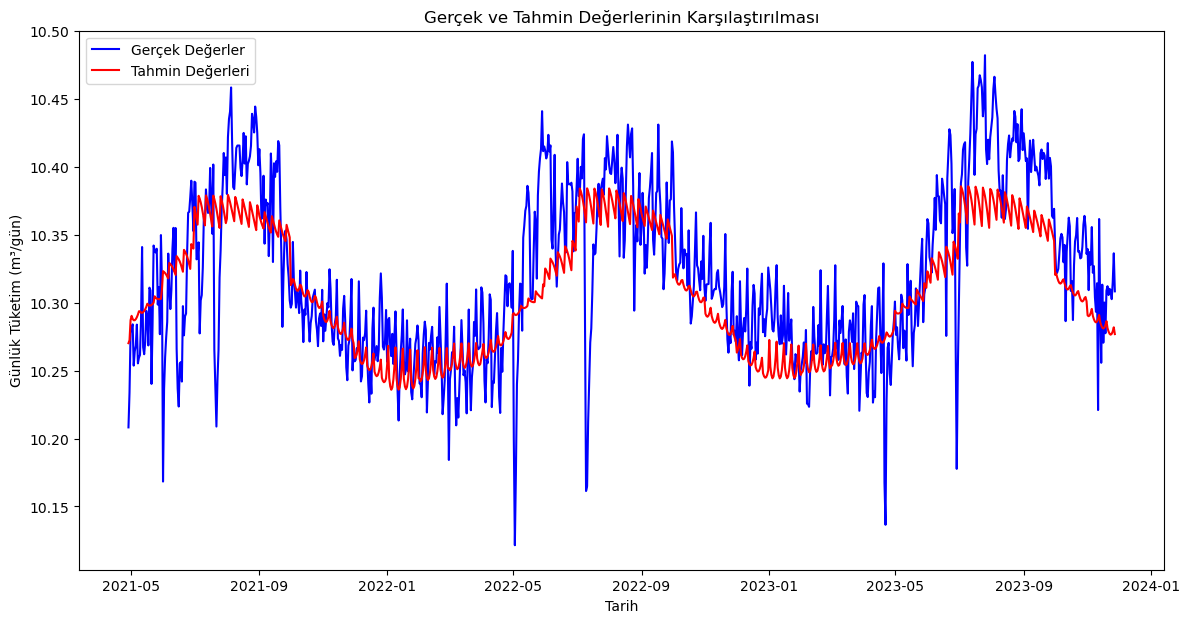

In [26]:
# Gerçek ve tahmin değerleri birleştirme
results = pd.DataFrame({'Tarih': test.index, 'Gerçek': y_test_orig.flatten(), 'Tahmin': y_pred_orig.flatten()})
results = results.set_index('Tarih')

# Görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.title('Gerçek ve Tahmin Değerlerinin Karşılaştırılması')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()

In [27]:
# Gelecek 10 gün için tahminler yapma
last_date = df.index[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 11)]

future_df = pd.DataFrame(index=future_dates)
future_df = create_features(future_df)

# Özellikleri normalize etme
future_scaled = scaler_X.transform(future_df[FEATURES])

# Veriyi 3 boyutlu hale getirme
future_scaled_reshaped = np.reshape(future_scaled, (future_scaled.shape[0], future_scaled.shape[1], 1))

# Gelecek 10 gün için tahminler yapma
future_pred_scaled = model.predict(future_scaled_reshaped)

# Tahminleri orijinal ölçeğe döndürme
future_pred_orig = scaler_y.inverse_transform(future_pred_scaled)

# Sonuçları birleştirme
future_df['Tahmin Edilen Su Tüketimi (m³/gün)'] = future_pred_orig
print(future_df[['Tahmin Edilen Su Tüketimi (m³/gün)']])

1/1 [==============================] - 0s 20ms/step
            Tahmin Edilen Su Tüketimi (m³/gün)
2023-11-28                           10.274362
2023-11-29                           10.272615
2023-11-30                           10.271949
2023-12-01                           10.264977
2023-12-02                           10.267862
2023-12-03                           10.271872
2023-12-04                           10.261601
2023-12-05                           10.259626
2023-12-06                           10.258623
2023-12-07                           10.258827


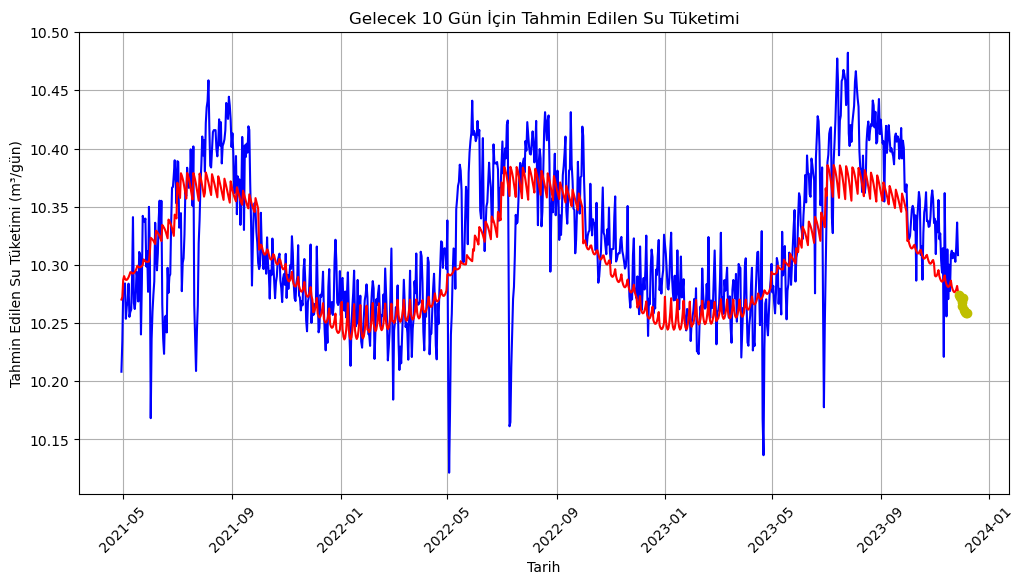

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.plot(future_df.index, future_df['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='y')
plt.title('Gelecek 10 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

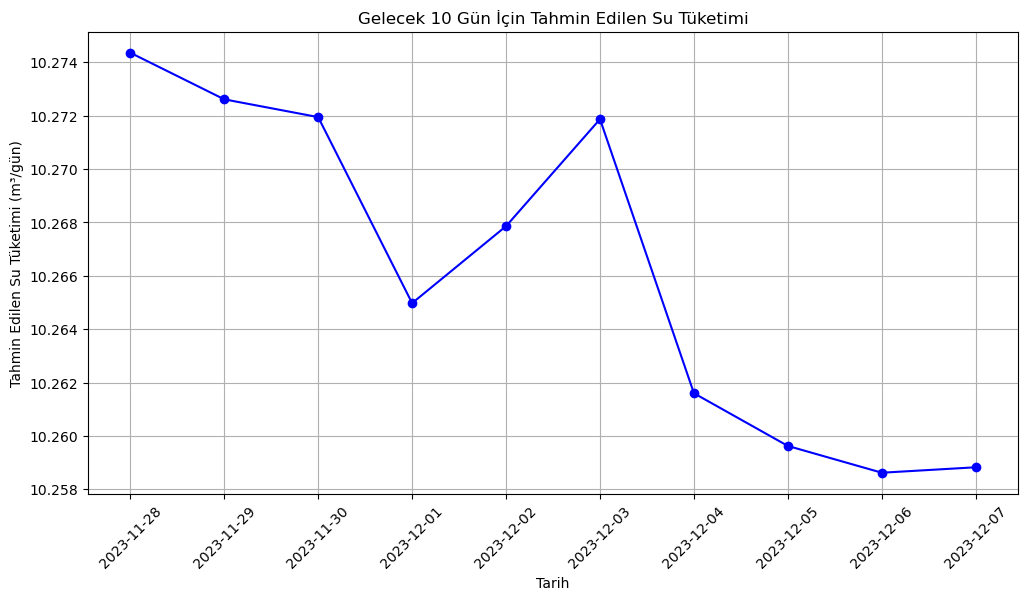

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='b')
plt.title('Gelecek 10 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [36]:
# Gelecek 365 gün için tahminler yapma
last_date = df.index[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 366)]

future_df = pd.DataFrame(index=future_dates)
future_df = create_features(future_df)

# Özellikleri normalize etme
future_scaled = scaler_X.transform(future_df[FEATURES])

# Veriyi 3 boyutlu hale getirme
future_scaled_reshaped = np.reshape(future_scaled, (future_scaled.shape[0], future_scaled.shape[1], 1))

# Gelecek 365 gün için tahminler yapma
future_pred_scaled = model.predict(future_scaled_reshaped)

# Tahminleri orijinal ölçeğe döndürme
future_pred_orig = scaler_y.inverse_transform(future_pred_scaled)

# Sonuçları birleştirme
future_df['Tahmin Edilen Su Tüketimi (m³/gün)'] = future_pred_orig
print(future_df[['Tahmin Edilen Su Tüketimi (m³/gün)']])

12/12 [==============================] - 0s 4ms/step
            Tahmin Edilen Su Tüketimi (m³/gün)
2023-11-28                           10.274362
2023-11-29                           10.272615
2023-11-30                           10.271949
2023-12-01                           10.264977
2023-12-02                           10.267862
...                                        ...
2024-11-22                           10.274209
2024-11-23                           10.275746
2024-11-24                           10.278274
2024-11-25                           10.273943
2024-11-26                           10.271614

[365 rows x 1 columns]


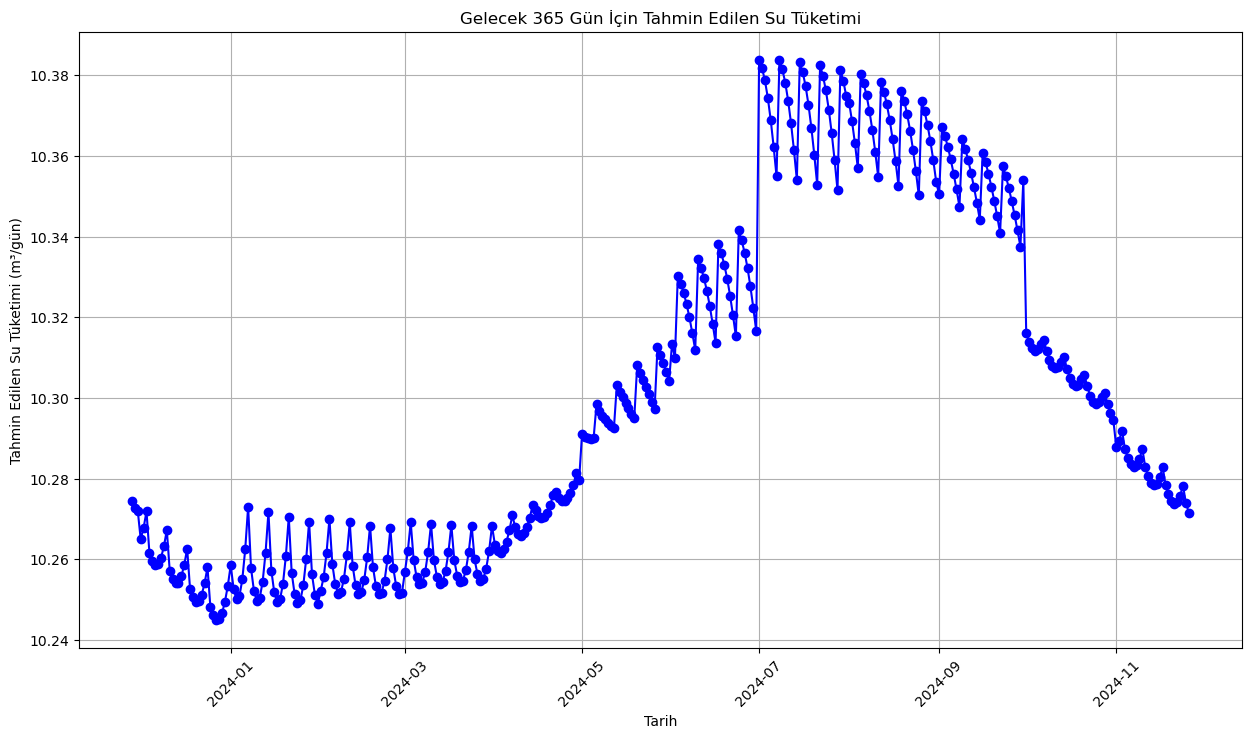

In [37]:
# Tahmin edilen su tüketimini görselleştirme
plt.figure(figsize=(15, 8))
plt.plot(future_df.index, future_df['Tahmin Edilen Su Tüketimi (m³/gün)'], marker='o', linestyle='-', color='b')
plt.title('Gelecek 365 Gün İçin Tahmin Edilen Su Tüketimi')
plt.xlabel('Tarih')
plt.ylabel('Tahmin Edilen Su Tüketimi (m³/gün)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()